# HowTo - 3 - Get offset stars and make finding charts

# 0) Load test data
### We begin again by loading the modules and the test data

In [1]:
import pandas as pd
from qso_toolbox import catalog_tools as ct, image_tools as it

loading dl.conf


In [2]:
df_hdf = pd.read_hdf('./data/stripe82_milliquas_190210.hdf5',key='data')

# We use the first 10 entries of the test set we used for HowTo-1-DownloadingImageCutouts
test_set = df_hdf.query('340 < mq_ra < 350 and -1.26 < mq_dec < 0')[:10]

test_set

,mq_ra,mq_dec,mq_name,mq_z,mq_cite
29552,340.029741,-0.892448,PGC 1132088,0.054,PGC
29553,340.032899,-1.256140,SDSS J224007.89-011522.1,0.659,DR14Q
29554,340.039043,-0.649055,SDSS J224009.37-003856.5,2.306,DR14Q
29556,340.047792,-1.246840,SDSS J224011.46-011448.6,1.451,DR14Q
29557,340.055801,-0.901223,SDSS J224013.39-005404.4,0.160,DR14
29559,340.059501,-0.189209,SDSS J224014.28-001121.1,2.235,DR14
29561,340.072023,-1.245235,SDSS J224017.28-011442.8,0.502,DR14Q
29562,340.076227,-0.873265,SDSS J224018.29-005223.7,2.561,DR14Q
29563,340.077436,-0.115803,SDSS J224018.58-000656.8,2.297,DR14Q
29567,340.094890,-0.031102,SDSS J224022.77-000151.9,0.910,DR14Q


# 1) Get offset stars 

### The main routines to get offset stars are found in catalog_tools. The routines use the astroquery package (get_astroquery_offset), the NOAO datalab python package (get_offset_stars_datalab) and the MAST website for PanSTARRS (get_offset_stars_ps1). Due to the way that different surveys scripted region queries, this seemed to be the most comfortable way of coding it up at this time. In the future one would want to consolidate these into one function.

### For each object in the supplied dataframe the function calls a region query around the object. The closest 'n' objects (fulfilling all specified criteria) are retrieved and stored in a new dataframe. After each object the new dataframe is stored in 'temp_offset_df.csv' in case one region query fails. In the end all functions return a dataframe with a maximum of 'n' offset starts per object.

### The dataframe includes the original target name, RA and Dec, the offset name (including its suffix), offset Ra and Dec, one magnitude for the offset, the separation (arcseconds), position angle, Ra and Dec offset (arcseconds).

### The offset stars in the dataframe will be given alphabetical suffices (e.g. '_A',' _B', etc.). Currently retrieval of a maximum of n=5 offset stars is possible.

### All offset star routines use essentially three different functions. 
### a) query_region_"astroquery, ps1, datalab"()
    Returns the catalog data of sources within a given radius of a defined
    position.
### b) get_"astroquery, ps1, datalab"_offset()
    Return the n nearest offset stars specified by the quality criteria
    around a given target.
### c) get_offset_stars_"astroquery, ps1, datalab"()
    Get offset stars for all targets in the input DataFrame.
    
### While one would usually use function c) to retrieve offset stars, functions a) and b) can also be used indepdently from c).




# 1.1) Astroquery offsets

### Currently options to get offset stars from 2MASS, NOMAD and VHSDR6 using the IRSA, Vizier and VSA astroquery services. It is trivial to add more surveys for these three services.

### These surveys are summarized in the internal variable astroquery_dict. Please have a look into the dictionary as it also sets, which magnitude will be retrieved.

    astroquery_dict = {
                        'tmass': {'service': 'irsa', 'catalog': 'fp_psc',
                                  'ra': 'ra', 'dec': 'dec', 'mag_name':
                                  'TMASS_J', 'mag': 'j_m', 'distance':
                                  'dist', 'data_release': None},
                        'nomad': {'service': 'vizier', 'catalog': 'NOMAD',
                                  'ra': 'RAJ2000', 'dec': 'DECJ2000',
                                  'mag_name': 'R', 'mag': 'Rmag', 'distance':
                                  'distance', 'data_release': None},
                        'vhsdr6': {'service': 'vsa', 'catalog': 'VHS',
                                   'ra': 'ra', 'dec': 'dec',
                                   'data_release': 'VHSDR6', 'mag_name': 'VHS_J',
                                   'mag': 'jAperMag3', 'distance': 'distance'}
                      }

## Example:
### We will retrieve offset stars for the test_set from VHS DR6. It will automatically retrieve the J-band magnitude ('jAperMag3') along with the position. The additional quality query ensures that we do not retrieve the target itself, limits the objects to a certain J-band magnitude range and set a simple quality flag for the J-band.

In [3]:
# Quality query needs to be written in pandas dataframe query syntax. Knowledge about the
# catalog columns returned from the query_region_astroquery() function is very useful.
quality_query = 'distance > 3/60. and 10 < jAperMag3 < 20 and jppErrBits==0'

offset_df = ct.get_offset_stars_astroquery(test_set, 'mq_name', 'mq_ra',
                     'mq_dec', 90, catalog='vhsdr6',
                                quality_query=quality_query, n=3, verbosity=2)



/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.0012114  -0.00040132  0.00191181] deg
Offset delta dec: [-0.0024384   0.00320341  0.00278962] deg
Offset separation: [ 9.80182575 11.62241203 12.17468909] arcsec
Offset position angle: [206.41818948 352.85932736  34.42399807] deg


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [ 0.00286052 -0.00470989 -0.01206559] deg
Offset delta dec: [-0.01137324  0.01193596  0.00623136] deg
Offset separation: [42.21882191 46.1937797  48.8869169 ] arcsec
Offset position angle: [165.88216324 338.46596684 297.31441355] deg


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.00060836 -0.00272547  0.00475394] deg
Offset delta dec: [-0.0023313   0.00393553 -0.00105412] deg
Offset separation: [ 8.67372452 17.233663   17.52987369] arcsec
Offset position angle: [194.62545674 325.29624938 102.50224451] deg


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [ 0.00520252 -0.00726854 -0.00950033] deg
Offset delta dec: [-0.00208068  0.00166241 -0.00377397] deg
Offset separation: [20.17138815 26.84241995 36.80095172] arcsec
Offset position angle: [111.79833477 282.88271637 248.3347299 ] deg


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.00131565  0.00111776 -0.00561021] deg
Offset delta dec: [ 0.00105948 -0.00212122  0.00054126] deg
Offset separation: [ 6.08114102  8.63170137 20.29054231] arcsec
Offset position angle: [308.84409236 152.21341916 275.51068414] deg


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.00435487 -0.00321254  0.01233154] deg
Offset delta dec: [ 0.00114861 -0.01040888  0.00289895] deg
Offset separation: [16.21365969 39.21608183 45.60375589] arcsec
Offset position angle: [284.77540046 197.15202006  76.77088473] deg


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.00094354 -0.00529269 -0.000493  ] deg
Offset delta dec: [-0.00752148 -0.00684434 -0.00895711] deg
Offset separation: [27.28955844 31.14727511 32.29439912] arcsec
Offset position angle: [187.15018806 217.7145727  183.1503829 ] deg


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.00294076 -0.00125798  0.00310035] deg
Offset delta dec: [-0.00107482 -0.0047893  -0.00635988] deg
Offset separation: [11.27167595 17.82634365 25.47118124] arcsec
Offset position angle: [249.92318713 194.71709552 154.01143548] deg


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.00105799  0.00416569 -0.00597535] deg
Offset delta dec: [-0.00276505  0.00268219  0.00386822] deg
Offset separation: [10.65798818 17.83622285 25.62529658] arcsec
Offset position angle: [200.93831609  57.22352185 302.91752587] deg


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.00185856 -0.00186384 -0.00098936] deg
Offset delta dec: [0.0027857  0.00283387 0.00472832] deg
Offset separation: [12.05563302 12.21069081 17.39058809] arcsec
Offset position angle: [326.28958936 326.66696164 348.18181296] deg


### Let's display (a few rows from) the offset dataframe:

In [4]:
offset_df[:5]

,target_name,target_ra,target_dec,offset_name,offset_shortname,offset_ra,offset_dec,jAperMag3,separation,pos_angle,dra_offset,ddec_offset
0,PGC 1132088,340.029741,-0.892448,PGC 1132088_offset_A,PGC 1132088_offset_A,340.030953,-0.890009,19.633066,9.801826,206.418189,-4.361024,-8.778227
1,PGC 1132088,340.029741,-0.892448,PGC 1132088_offset_B,PGC 1132088_offset_B,340.030142,-0.895651,19.439920,11.622412,352.859327,-1.444734,11.532268
2,PGC 1132088,340.029741,-0.892448,PGC 1132088_offset_C,PGC 1132088_offset_C,340.027829,-0.895237,19.562323,12.174689,34.423998,6.882505,10.042618
3,SDSS J224007.89-011522.1,340.032899,-1.256140,SDSS J224007.89-011522.1_offset_A,SDSS J224007.89-011522.1_offset_A,340.030038,-1.244767,19.275267,42.218822,165.882163,10.297886,-40.943650
4,SDSS J224007.89-011522.1,340.032899,-1.256140,SDSS J224007.89-011522.1_offset_B,SDSS J224007.89-011522.1_offset_B,340.037610,-1.268076,17.606583,46.193780,338.465967,-16.955604,42.969440


# 1.2) Datalab offsets

### The datalab version offers access to a different range of surveys than astroquery. At this point only access to DES DR1 data is included here. Similar to the astroquery routines a simple dictionary sets this limitation an can be easily expanded. The current dictionary reads:

    datalab_offset_dict = {'des_dr1.main': {'ra': 'ra', 'dec': 'dec',
                                          'mag': 'mag_auto_z',
                                          'mag_name': 'mag_auto_z'}}
                                          
### Main difference to the astroquery offset routines:  The 'quality_query' keyword argument is replaced by 'where', which is now in ADQL (Astronomical Data Query Language) syntax.
                                          
## Example:
### We will again provide a quick example. 

In [5]:
# The where keyword argument will be added to the ADQL query to the NOAO datalab.
where = 'mag_auto_z > 15 AND mag_auto_z < 19'

offset_df = ct.get_offset_stars_datalab(test_set, 'mq_name', 'mq_ra',
                     'mq_dec', 90, survey='des_dr1', table='main',
                             n=3, where=where, verbosity=2)

SQL QUERY: SELECT * , q3c_dist(ra, dec, 340.029741, -0.8924476999999998) as distance FROM des_dr1.main WHERE q3c_radial_query(ra, dec, 340.029741, -0.8924476999999998, 0.025) AND mag_auto_z > 15 AND mag_auto_z < 19


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [0.00010499 0.01518616] deg
Offset delta dec: [-0.0041647   0.00690527] deg
Offset separation: [14.99768314 60.05660193] arcsec
Offset position angle: [178.55594561  65.54832375] deg
SQL QUERY: SELECT * , q3c_dist(ra, dec, 340.03289900000004, -1.25614) as distance FROM des_dr1.main WHERE q3c_radial_query(ra, dec, 340.03289900000004, -1.25614, 0.025) AND mag_auto_z > 15 AND mag_auto_z < 19


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.00471587 -0.01311885  0.01235603] deg
Offset delta dec: [0.011926   0.00489497 0.01257997] deg
Offset separation: [46.16833616 50.40833555 63.47925417] arcsec
Offset position angle: [338.42479597 290.46179221  44.48546263] deg
SQL QUERY: SELECT * , q3c_dist(ra, dec, 340.039043, -0.6490545999999999) as distance FROM des_dr1.main WHERE q3c_radial_query(ra, dec, 340.039043, -0.6490545999999999, 0.025) AND mag_auto_z > 15 AND mag_auto_z < 19


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.00057796  0.02036069 -0.01581599] deg
Offset delta dec: [-0.0023106  -0.00838964 -0.01625762] deg
Offset separation: [ 8.57443647 79.27719167 81.65382051] arcsec
Offset position angle: [194.04354592 112.39415059 224.21111312] deg
SQL QUERY: SELECT * , q3c_dist(ra, dec, 340.0477915, -1.24684) as distance FROM des_dr1.main WHERE q3c_radial_query(ra, dec, 340.0477915, -1.24684, 0.025) AND mag_auto_z > 15 AND mag_auto_z < 19


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.00727478  0.00177008 -0.01760633] deg
Offset delta dec: [0.00164799 0.014195   0.01153094] deg
Offset separation: [26.8527794  51.49776961 75.76657081] arcsec
Offset position angle: [282.76405434   7.1079499  303.22205304] deg
SQL QUERY: SELECT * , q3c_dist(ra, dec, 340.055801, -0.9012233000000001) as distance FROM des_dr1.main WHERE q3c_radial_query(ra, dec, 340.055801, -0.9012233000000001, 0.025) AND mag_auto_z > 15 AND mag_auto_z < 19


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [ 1.49981444e-05 -2.18572959e-03 -5.58130949e-03] deg
Offset delta dec: [-7.63000000e-05  3.32769934e-03  5.50695721e-04] deg
Offset separation: [ 0.27993639 14.33279169 20.19028199] arcsec
Offset position angle: [168.87926344 326.7019283  275.63501148] deg
SQL QUERY: SELECT * , q3c_dist(ra, dec, 340.05950099999995, -0.18920889999999999) as distance FROM des_dr1.main WHERE q3c_radial_query(ra, dec, 340.05950099999995, -0.18920889999999999, 0.025) AND mag_auto_z > 15 AND mag_auto_z < 19


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.00433998 -0.01702591  0.0179049 ] deg
Offset delta dec: [ 0.0011341   0.00376909 -0.00393591] deg
Offset separation: [16.14854876 62.77718421 65.99664198] arcsec
Offset position angle: [284.64474871 282.48248162 102.39774425] deg
SQL QUERY: SELECT * , q3c_dist(ra, dec, 340.0720225, -1.245235) as distance FROM des_dr1.main WHERE q3c_radial_query(ra, dec, 340.0720225, -1.245235, 0.025) AND mag_auto_z > 15 AND mag_auto_z < 19


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [ 0.00234795  0.00661894 -0.01179771] deg
Offset delta dec: [-0.012993    0.01313599  0.01004497] deg
Offset separation: [47.53239705 52.95361346 55.78112923] arcsec
Offset position angle: [169.75671248  26.74252749 310.41220019] deg
SQL QUERY: SELECT * , q3c_dist(ra, dec, 340.0762269, -0.8732648999999999) as distance FROM des_dr1.main WHERE q3c_radial_query(ra, dec, 340.0762269, -0.8732648999999999, 0.025) AND mag_auto_z > 15 AND mag_auto_z < 19


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.00292676  0.0034055   0.00049784] deg
Offset delta dec: [-0.0010709  0.0064461  0.0110371] deg
Offset separation: [11.21950468 26.24536925 39.77395977] arcsec
Offset position angle: [249.90243324  27.84770646   2.58264709] deg
SQL QUERY: SELECT * , q3c_dist(ra, dec, 340.0774356, -0.11580309999999999) as distance FROM des_dr1.main WHERE q3c_radial_query(ra, dec, 340.0774356, -0.11580309999999999, 0.025) AND mag_auto_z > 15 AND mag_auto_z < 19


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.0010544   0.00417359  0.0010916 ] deg
Offset delta dec: [-0.0027961  0.0026559 -0.0074991] deg
Offset separation: [10.75787593 17.80914905 27.28127572] arcsec
Offset position angle: [200.66125356  57.52902425 171.71797506] deg
SQL QUERY: SELECT * , q3c_dist(ra, dec, 340.0948901, -0.031101900000000002) as distance FROM des_dr1.main WHERE q3c_radial_query(ra, dec, 340.0948901, -0.031101900000000002, 0.025) AND mag_auto_z > 15 AND mag_auto_z < 19


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.0018909  0.0094661 -0.0102639] deg
Offset delta dec: [ 0.0027791  0.0137751 -0.0187979] deg
Offset separation: [12.1009803  60.17067929 77.10294666] arcsec
Offset position angle: [325.76862774  34.49642665 208.63511578] deg


### Let's display (a few rows from) the offset dataframe:

In [6]:
offset_df[:5]

,target_name,target_ra,target_dec,offset_name,offset_shortname,offset_ra,offset_dec,mag_auto_z,separation,pos_angle,dra_offset,ddec_offset
0,PGC 1132088,340.029741,-0.892448,PGC 1132088_offset_A,PGC 1132088_offset_A,340.029636,-0.888283,18.5337,14.997683,178.555946,0.377954,-14.992920
1,PGC 1132088,340.029741,-0.892448,PGC 1132088_offset_B,PGC 1132088_offset_B,340.014553,-0.899353,17.8420,60.056602,65.548324,54.670168,24.858966
2,SDSS J224007.89-011522.1,340.032899,-1.256140,SDSS J224007.89-011522.1_offset_A,SDSS J224007.89-011522.1_offset_A,340.037616,-1.268066,18.2898,46.168336,338.424796,-16.977120,42.933585
3,SDSS J224007.89-011522.1,340.032899,-1.256140,SDSS J224007.89-011522.1_offset_B,SDSS J224007.89-011522.1_offset_B,340.046021,-1.261035,16.7347,50.408336,290.461792,-47.227848,17.621881
4,SDSS J224007.89-011522.1,340.032899,-1.256140,SDSS J224007.89-011522.1_offset_C,SDSS J224007.89-011522.1_offset_C,340.020540,-1.268720,17.6612,63.479254,44.485463,44.481709,45.287894


# 1.3) PanSTARRS offsets

### The PanSTARRS version of the offset query uses the MAST website to query the archive using a url and retrieving the provided data table. 
### The 'qualiy_query' keyword argument in pandas query syntax then applies quality criteria to the retrieved data table.

### WARNING: As the response from the MAST PanSTARRS archive is slow the routine will take a while for large target catalogs.

## Example:

In [7]:
quality_query = '10 < zMeanPSFMag < 19'

offset_df = ct.get_offset_stars_ps1(test_set, 'mq_name', 'mq_ra',
                     'mq_dec', 90, data_release='dr2',
                     catalog='mean', quality_query=quality_query, verbosity=2)

Querying PS1 Archive (mean,dr2) for PGC 1132088
Opening https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean?ra=340.029741&dec=-0.8924476999999998&radius=0.025&format=csv


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [1.45982289e-06 2.37774153e-03 3.02893253e-03] deg
Offset delta dec: [-2.69500000e-05  9.25969231e-04 -5.95621246e-04] deg
Offset separation: [ 0.09716223  9.1860501  11.11298305] arcsec
Offset position angle: [176.89944231  68.722457   101.1249217 ] deg
Querying PS1 Archive (mean,dr2) for SDSS J224007.89-011522.1
Opening https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean?ra=340.03289900000004&dec=-1.25614&radius=0.025&format=csv


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [ 0.00452541 -0.0008971  -0.01315972] deg
Offset delta dec: [0.01307324 0.01382722 0.00491608] deg
Offset separation: [49.80361017 49.8826482  50.57275542] arcsec
Offset position angle: [ 19.09373193 356.28787598 290.48418512] deg
Querying PS1 Archive (mean,dr2) for SDSS J224009.37-003856.5
Opening https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean?ra=340.039043&dec=-0.6490545999999999&radius=0.025&format=csv


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.00060767  0.01069517  0.01626069] deg
Offset delta dec: [-0.00226691 -0.00203825 -0.00522396] deg
Offset separation: [ 8.44899765 39.19558742 61.48518041] arcsec
Offset position angle: [195.00599653 100.78985683 107.8102872 ] deg
Querying PS1 Archive (mean,dr2) for SDSS J224011.46-011448.6
Opening https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean?ra=340.0477915&dec=-1.24684&radius=0.025&format=csv


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.00237708 -0.01003844  0.00644823] deg
Offset delta dec: [ 0.00609278 -0.00461674 -0.0126368 ] deg
Offset separation: [23.54423403 39.77708574 51.07286996] arcsec
Offset position angle: [338.68692555 245.30201939 152.96594845] deg
Querying PS1 Archive (mean,dr2) for SDSS J224013.39-005404.4
Opening https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean?ra=340.055801&dec=-0.9012233000000001&radius=0.025&format=csv


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-1.56580629e-05 -2.16037273e-03 -2.34144033e-03] deg
Offset delta dec: [-2.78900000e-05  3.32337936e-03  3.72612924e-03] deg
Offset separation: [ 0.11514526 14.26983904 15.84261058] arcsec
Offset position angle: [209.3108177  326.97399773 327.8553995 ] deg
Querying PS1 Archive (mean,dr2) for SDSS J224014.28-001121.1
Opening https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean?ra=340.05950099999995&dec=-0.18920889999999999&radius=0.025&format=csv


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [ 0.00678826 -0.00867428  0.00979795] deg
Offset delta dec: [ 0.0048688  -0.00749627  0.00616442] deg
Offset separation: [30.07362405 41.27259505 41.67298121] arcsec
Offset position angle: [ 54.35047997 229.16658657  57.82378587] deg
Querying PS1 Archive (mean,dr2) for SDSS J224017.28-011442.8
Opening https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean?ra=340.0720225&dec=-1.245235&radius=0.025&format=csv


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [ 0.01418683  0.00658335 -0.01183106] deg
Offset delta dec: [-0.00301176  0.01318229  0.01007436] deg
Offset separation: [52.21077394 53.04514743 55.94111191] arcsec
Offset position angle: [101.98552655  26.53791994 310.41501107] deg
Querying PS1 Archive (mean,dr2) for SDSS J224018.29-005223.7
Opening https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean?ra=340.0762269&dec=-0.8732648999999999&radius=0.025&format=csv


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [ 0.00226127 -0.00296043  0.00337218] deg
Offset delta dec: [-0.00085873 -0.00103575  0.00648124] deg
Offset separation: [ 8.70779525 11.29098163 26.30169921] arcsec
Offset position angle: [110.79459255 250.71681587  27.48788996] deg
Querying PS1 Archive (mean,dr2) for SDSS J224018.58-000656.8
Opening https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean?ra=340.0774356&dec=-0.11580309999999999&radius=0.025&format=csv


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [0.00416033 0.00106875 0.00134059] deg
Offset delta dec: [ 0.00270185 -0.007458   -0.00977982] deg
Offset separation: [17.85844942 27.12307617 35.53658707] arcsec
Offset position angle: [ 56.99904276 171.84490923 172.1947177 ] deg
Querying PS1 Archive (mean,dr2) for SDSS J224022.77-000151.9
Opening https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean?ra=340.0948901&dec=-0.031101900000000002&radius=0.025&format=csv


/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Offset delta ra: [-0.00443205 -0.00344264 -0.00841481] deg
Offset delta dec: [0.00674711 0.01366712 0.01211569] deg
Offset separation: [29.06128924 50.73854023 53.10444691] arcsec
Offset position angle: [326.69984249 345.86176978 325.21854602] deg


### Let's display (a few rows from) the offset dataframe:

In [8]:
offset_df[:5]

,target_name,target_ra,target_dec,offset_name,offset_shortname,offset_ra,offset_dec,ps1_dr2_mean_psfmag_z,separation,pos_angle,dra_offset,ddec_offset
0,PGC 1132088,340.029741,-0.892448,PGC 1132088_offset_A,PGC 1132088_offset_A,340.029740,-0.892421,16.445601,0.097162,176.899442,0.005255,-0.097020
1,PGC 1132088,340.029741,-0.892448,PGC 1132088_offset_B,PGC 1132088_offset_B,340.027363,-0.893374,17.047400,9.186050,68.722457,8.559870,3.333489
2,PGC 1132088,340.029741,-0.892448,PGC 1132088_offset_C,PGC 1132088_offset_C,340.026712,-0.891852,17.070200,11.112983,101.124922,10.904157,-2.144236
3,SDSS J224007.89-011522.1,340.032899,-1.256140,SDSS J224007.89-011522.1_offset_A,SDSS J224007.89-011522.1_offset_A,340.028372,-1.269213,13.803100,49.803610,19.093732,16.291484,47.063650
4,SDSS J224007.89-011522.1,340.032899,-1.256140,SDSS J224007.89-011522.1_offset_B,SDSS J224007.89-011522.1_offset_B,340.033796,-1.269967,17.063801,49.882648,356.287876,-3.229576,49.777991


# 2) Get Finding Charts

### The qso_toolbox image_tools package also provides routines for finding chart generation. However, before finding charts can be made the images need to be downloaded and, if necessary, offset stars need to be found.

### The following example downloads the images and retrives offset starts for our test set:

In [9]:
# Download finding chart images 
surveys = ['vhsdr6']
bands = ['J']
fovs = [300]

ct.get_photometry(test_set, 'mq_ra', 'mq_dec', surveys, bands, './cutouts/', fovs, verbosity=0)


# Get offset stars
quality_query = 'distance > 3/60. and 10 < jAperMag3 < 20 and jppErrBits==0'

offset_df = ct.get_offset_stars_astroquery(test_set, 'mq_name', 'mq_ra',
                     'mq_dec', 90, catalog='vhsdr6',
                                quality_query=quality_query, n=3, verbosity=0)



/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/schindler/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

### Now we are ready to produce finding charts. The routine that you probably want to use is image_tools.make_finding_charts(). It generates finding charts for the entire target list (pandas dataframe) and saves them either in png or pdf format.

### Before we demonstrate this routine, we will show how you generate only one finding chart in the following example:

/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute font. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


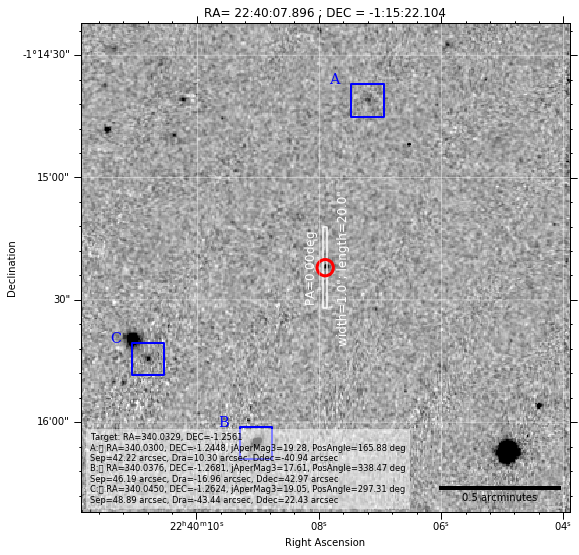

In [10]:
# We first reduce the offsets in the catalog to the ones for this particular target 
offset_target = offset_df.query('target_name=="{}"'.format('SDSS J224007.89-011522.1'))

# Make one finding chart 
ra = test_set.loc[test_set.index[1],'mq_ra']
dec = test_set.loc[test_set.index[1],'mq_dec']

it._make_finding_chart(ra, dec, 'vhsdr6', 'J', 2, 120,
                        './cutouts/',
                        offset_target,
                        offset_ra_column_name='offset_ra',
                        offset_dec_column_name='offset_dec',
                        offset_mag_column_name='jAperMag3',
                        offset_id_column_name='offset_shortname',
                        label_position='topleft',
                        slit_width=1.0, slit_length=20,
                        position_angle=0, verbosity=0)

### Generating finding charts for your entire target catalog is comparatively easy. You just call the function below supplied with your target catalog and the offset star catalog.

/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute font. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


fc_PGC 1132088 created


/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute font. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


fc_SDSS J224007.89-011522.1 created


/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute font. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


fc_SDSS J224009.37-003856.5 created


/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute font. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


fc_SDSS J224011.46-011448.6 created


/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute font. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


fc_SDSS J224013.39-005404.4 created


/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute font. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


fc_SDSS J224014.28-001121.1 created


/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute font. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


fc_SDSS J224017.28-011442.8 created


/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute font. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


fc_SDSS J224018.29-005223.7 created


/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute font. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


fc_SDSS J224018.58-000656.8 created


/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute font. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:274: UserWarning: Scalebar does not have attribute font. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/Users/schindler/anaconda3/lib/python3.6/site-packages/aplpy/overlays.py:258: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


fc_SDSS J224022.77-000151.9 created


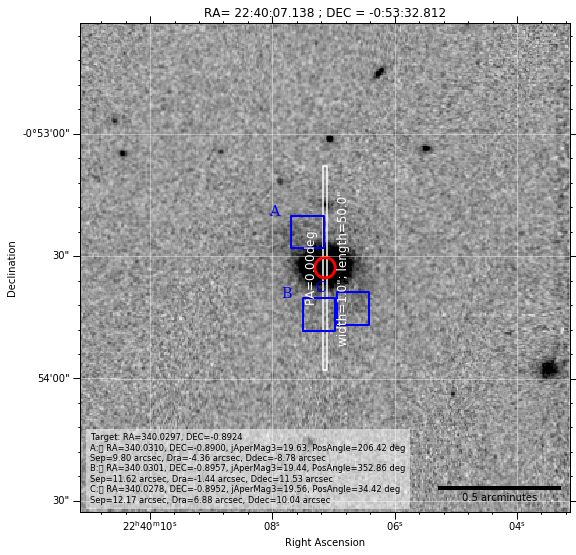

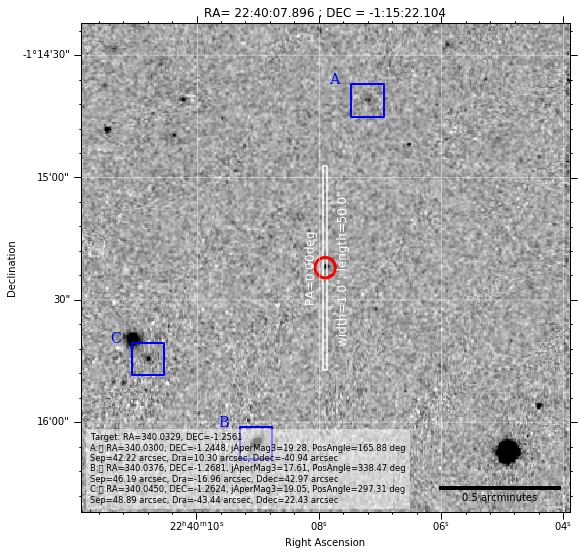

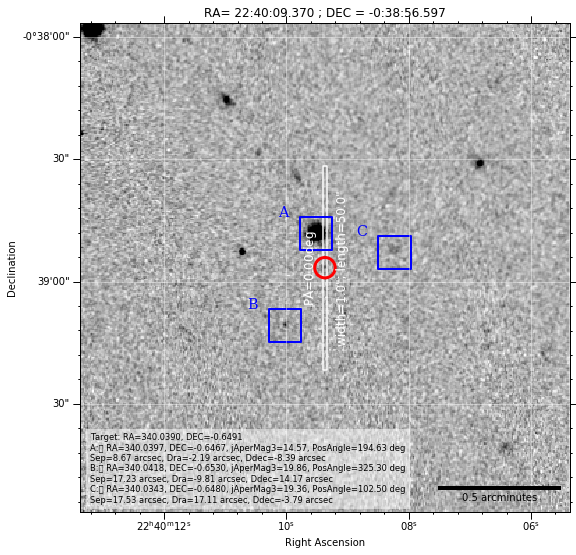

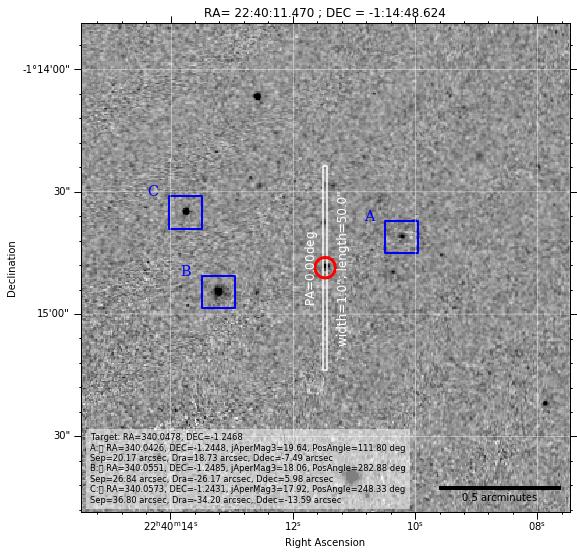

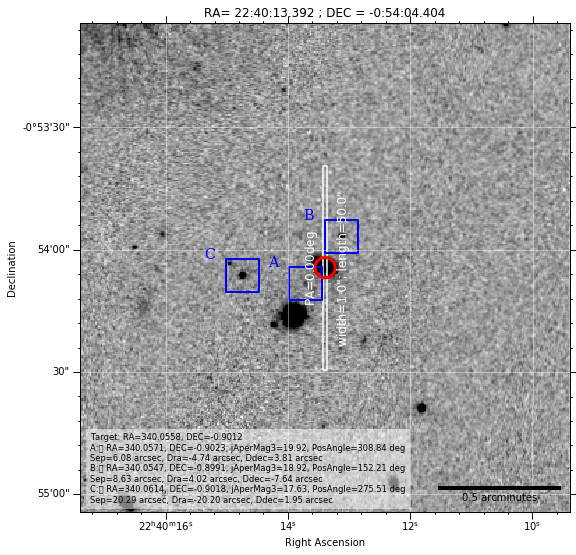

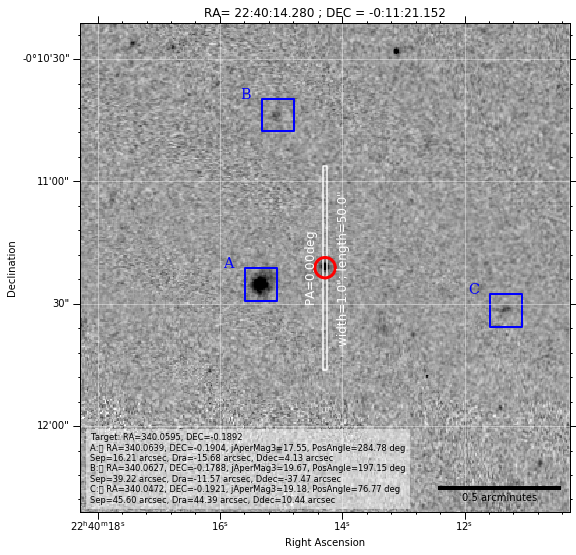

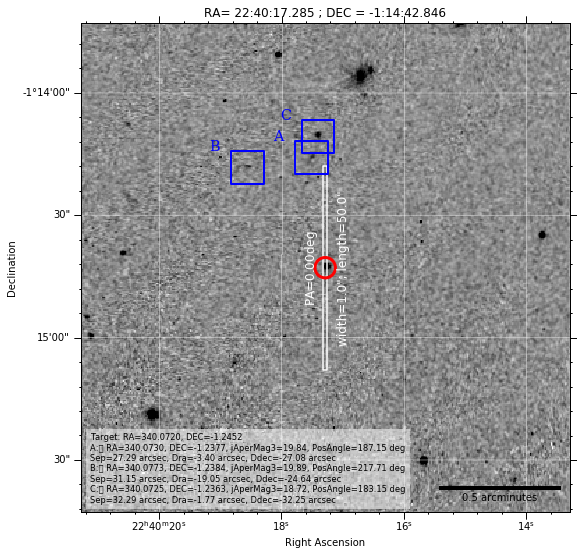

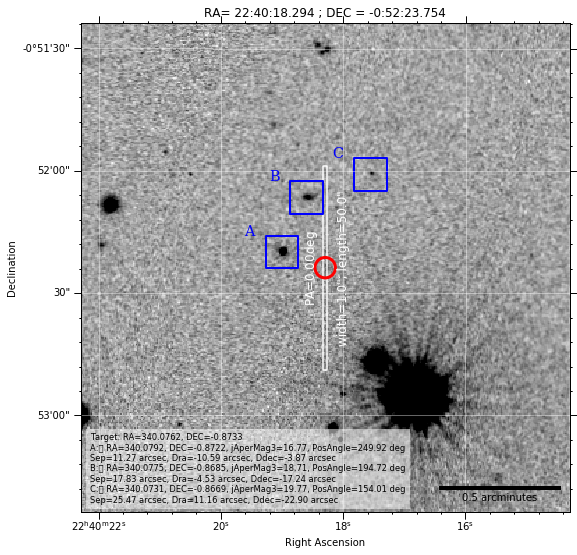

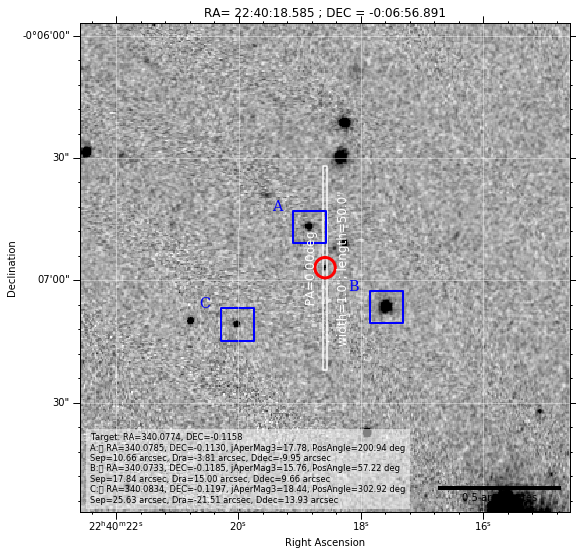

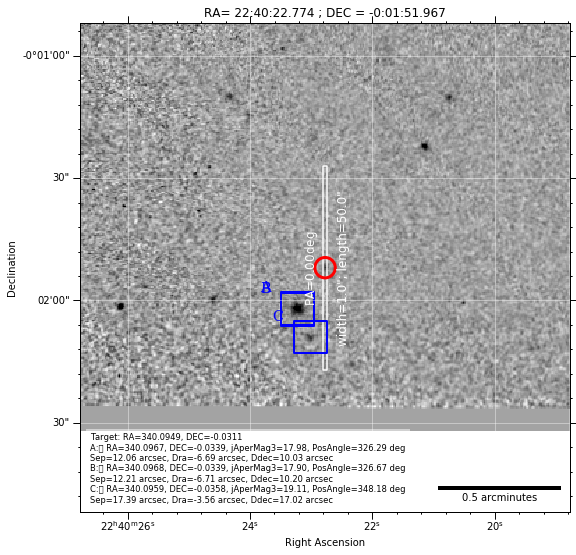

In [11]:
# Make finding charts
it.make_finding_charts(test_set, 'mq_ra', 'mq_dec',
                        'mq_name', 'vhsdr6', 'J',
                        2.5, 120, './cutouts',
                        offset_df,
                        offset_ra_column_name='offset_ra',
                        offset_dec_column_name='offset_dec',
                        pos_angle_column_name=None,
                        offset_mag_column_name='jAperMag3',
                        offset_id_column_name='offset_shortname',
                        label_position='topleft',
                        slit_width=1.0, slit_length=50,
                        format='png', verbosity=0)

### In the end make sure that your finding charts reflect the depth, sensitivity and field of view of your acquisition camera. So you will likely need to tweak the code here and there.
### In addition, make sure to check all finding charts! If you take a look at the once we generated you will notice that a few extended sources are selected as offset stars. This should not be the case, so make sure to include the necessary quality criteria when you retrieve offset stars.